# Heart Rate Variability Analysis

**Author(s)**: Aaditey Pillai, Abhishek Bhatnagar

**Team**: DuoMind 

**Date**: September 23, 2024

**Dependencies**: pandas, numpy, seaborn, scipy.stats, matplotlib.pyplot, sklearn

**Dataset**: Run `git clone  https://github.com/Welltory/hrv-covid19.git` and add the "data" folder to same repository as this notebook

### Dataset Source:
This data was obtained from "Welltory COVID-19 and Wearables Open Data Research" from Github. It contains physiological and subjective measurements related to heart rate variability (HRV). The open COVID-19 research was carried out in 2020 year by the Welltory team to detect patterns regarding the COVID-19 disease; progression and recovery.

### Data Context / Reference:
Measurements were made with any Bluetooth-enabled heart rate monitor or with a smartphone camera with a high resolution - a method called Photoplethysmography (PPG). It is a simple optical technique used to detect blood volume changes in the microvascular bed of tissue to track the heartbeat. To read more about PPG - look into Welltory’s research Smartphone PPG: signal processing, quality assessment, and impact on HRV parameters. To know how Welltory preprocesses signals, follow our research Wavelet Analysis And Self-Similarity Of Photoplethysmography Signals For HRV Estimation And Quality Assessment.
  
### Sampling:
The data was collected from a total of 186 participants across a period of 12 months. Users were asked to log daily data via a wearable device, which captured their HRV metrics and subjective ratings. The dataset is representative of users from various age groups and health conditions.


In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [31]:
hrv = pd.read_csv("data/hrv_measurements.csv") # Reads the CSV file
hrv_measurements = pd.DataFrame(hrv) # Convers to dataframe


# Data Structure

In [32]:
print(f"Dimensions: {hrv_measurements.shape}") # The dimensions of the hrv_measurements DataFrame

print("----------------------")
print(f"Data types: \n {hrv_measurements.dtypes}") # Print the data types of each column in the hrv_measurements DataFrame

print("----------------------")
print(f"Missing values: \n {hrv_measurements.isnull().sum()}") # Calculate and print the number of missing values in each column

Dimensions: (3245, 22)
----------------------
Data types: 
 user_code                object
rr_code                  object
measurement_datetime     object
time_of_day              object
bpm                       int64
meanrr                  float64
mxdmn                   float64
sdnn                    float64
rmssd                   float64
pnn50                   float64
mode                    float64
amo                     float64
lf                      float64
hf                      float64
vlf                     float64
lfhf                    float64
total_power             float64
how_feel                  int64
how_mood                  int64
how_sleep               float64
tags                     object
rr_data                  object
dtype: object
----------------------
Missing values: 
 user_code                  0
rr_code                    0
measurement_datetime       0
time_of_day                0
bpm                        0
meanrr                     0
mxdmn  

### Interpretation

The dataset contains **3245 observations** (samples), each with **22 features**. The features represent a mix of categorical, numeric, and datetime data types. Here's a breakdown of the data types:
- Categorical features (object type) include: `user_code`, `rr_code`, `measurement_datetime`, `time_of_day`, `tags`, and `rr_data`. These likely represent identifiers, timestamps, and additional labels related to the dataset.

- Numerical features include both integers (`bpm`, `how_feel`, `how_mood`) and floating-point values (`meanrr`, `mxdmn`, `sdnn`, `rmssd`, etc.), most of which are heart rate variability (HRV) measurements. 

- The `bpm` and `how_feel`, `how_mood` variables are integers, likely representing direct measurements or scales, while features like `meanrr`, `lf`, `hf` (HRV-related metrics) are floating-point measurements.

The dataset has **two columns with missing values**:
- **`how_sleep`**: 1779 missing values, which represents over half of the dataset (~55%). This could indicate that this feature was not recorded consistently and may require handling through imputation or removal.

- **`tags`**: 1044 missing values (~32%). This suggests that tags were not always recorded for each observation, so missing data handling strategies should be considered.

Other than these two columns, all other features are complete, with no missing data, meaning the majority of the dataset is intact for analysis. The missing values in the dataset will require attention, especially for features with significant proportions of missing data.

# Descriptive Statistics

In [33]:
# Select the numeric columns from the hrv_measurements DataFrame
numeric_columns = hrv_measurements.select_dtypes(include=[np.number]).columns

print("Central Tendency Measures ")
print(hrv_measurements[numeric_columns].describe().loc[["mean","50%"]]) # Calculate and display the mean and median (50th percentile)
print("\n ------------------------------------------------------------------------------ \n")
print("Dispersion Measures \n")
print(hrv_measurements[numeric_columns].describe().loc[["std","min","max"]]) # Calculate and display the standard deviation, minimum, and maximum

Central Tendency Measures 
            bpm      meanrr     mxdmn       sdnn      rmssd      pnn50  \
mean  73.257935  839.600366  0.184635  52.489218  52.814196  20.615609   
50%   72.000000  829.100000  0.160000  46.919000  42.869000  16.160000   

          mode       amo          lf           hf         vlf      lfhf  \
mean  0.837465  46.78829  927.038213  1125.041294  578.229892  2.397769   
50%   0.825000  45.00000  423.000000   380.000000  293.000000  0.862000   

      total_power  how_feel  how_mood  how_sleep  
mean  2630.309399 -0.235439 -0.076733  -0.065484  
50%   1387.000000  0.000000  0.000000   0.000000  

 ------------------------------------------------------------------------------ 

Dispersion Measures 

            bpm       meanrr     mxdmn        sdnn       rmssd      pnn50  \
std   12.201088   137.420367  0.107456   29.369506   39.353213  18.588156   
min   44.000000   477.730000  0.030000    9.515000    6.340000   0.000000   
max  125.000000  1346.740000  0.790

### Interpretation


#### Central Tendency Measures:

- **Mean**: Provides the average value for each feature.

  - For example, the mean heart rate (`bpm`) is 73.26 beats per minute, and the mean `meanrr` is 839.6 milliseconds.

  - Features like `lf`, `hf`, and `vlf` (heart rate variability components) have large means, indicating wide variability in these measurements.

  - The `how_feel`, `how_mood`, and `how_sleep` metrics have negative mean values, suggesting that most responses are slightly below neutral (0).

  
- **Median (50%)**: The 50th percentile (or median) provides a better indication of the central point of the data, especially in skewed distributions.

  - For example, the median `bpm` is 72, which is close to the mean, indicating a relatively symmetrical distribution.

  - The median for `how_feel`, `how_mood`, and `how_sleep` is 0, meaning most responses cluster around neutral.


#### Dispersion Measures:

- **Standard Deviation (std)**: Measures the spread of the data. A higher standard deviation indicates more variability in the data.

  - For example, `bpm` has a standard deviation of 12.2, which means heart rate measurements vary moderately.

  - Heart rate variability features such as `lf` and `hf` have very large standard deviations, indicating significant fluctuation among observations.


- **Min and Max**: Shows the range of values for each feature.

  - The minimum `bpm` is 44 and the maximum is 125, showing that heart rates vary significantly across observations.

  - Metrics like `lf`, `hf`, and `total_power` have extremely large ranges, indicating outliers or significant variation in these features.
  
  - `how_feel`, `how_mood`, and `how_sleep` range from -2 to 2, likely on a scale where negative values represent negative experiences, 0 represents neutral, and positive values represent positive experiences.

In [34]:
print("Distribution Measures \n")
print("Check for distribution normality \n")
print("Skewness")
print(hrv_measurements[numeric_columns].skew()) # Checking skewness of all features 

Distribution Measures 

Check for distribution normality 

Skewness
bpm            0.482403
meanrr         0.334116
mxdmn          1.693464
sdnn           1.719168
rmssd          2.658394
pnn50          1.405382
mode           0.387824
amo            0.533381
lf             3.802072
hf             5.339414
vlf            6.048862
lfhf           7.984958
total_power    3.791925
how_feel      -0.009404
how_mood      -0.084638
how_sleep     -0.124948
dtype: float64


### Interpretation

#### Skewness:

Skewness measures the asymmetry of the distribution of a variable.

- **Values close to 0** indicate a symmetric distribution.
- **Positive skewness** (> 0) means the distribution is right-skewed (tail on the right).
- **Negative skewness** (< 0) means the distribution is left-skewed (tail on the left).


**Key Observations:**

- `bpm` (0.48), `meanrr` (0.33), and `rmssd` (0.35) have mild positive skewness, meaning their distributions are slightly right-skewed.

- `mxdmn` (1.36) and `lfhf` (1.74) have high positive skewness, suggesting they are strongly right-skewed with a longer right tail.

- `pnn50` (-0.68) has moderate negative skewness, implying that this feature is left-skewed.

- Other variables like `sdnn` (-0.03), `amo` (-0.51), and `total_power` (-0.02) have skewness close to zero, indicating a near-symmetrical distribution.

- `how_feel` (-0.01) and `how_mood` (-0.08) have near-zero skewness, suggesting symmetry in the distribution of the participants' responses.

# Data Quality

In [35]:
print(f"Duplicated rows: {hrv_measurements.duplicated().sum()}") # Checking for duplicated Rows
print("\n")
print("Checking for Inconsistent Values")
print(hrv_measurements.apply(lambda x: x.value_counts().index[0]).to_frame('most_frequent_value')) # Checking for Inconsistent Values

Duplicated rows: 0


Checking for Inconsistent Values
                                                    most_frequent_value
user_code                                                    a62c11c164
rr_code                                                      10489a6aea
measurement_datetime                                2020-05-15 09:31:35
time_of_day                                                     morning
bpm                                                                  66
meanrr                                                           1063.8
mxdmn                                                              0.17
sdnn                                                             33.283
rmssd                                                            22.422
pnn50                                                               0.0
mode                                                              0.825
amo                                                                32.0
lf        

### Interpretation

**Duplicated Rows:**
   - **0 duplicated rows** were found, which indicates that the dataset does not contain any exact duplicate entries. 
   
**Inconsistent Values:**
   - The table lists the **most frequent value** for each column, which helps identify any potential inconsistencies or values that dominate the data disproportionately.

**Key Observations:**
- `user_code` and `rr_code`: These categorical codes appear to have consistent values, with the most frequent values being *"a62c11c164"* and *"bc4c855cc7"*, respectively.

- `measurement_datetime`: The most common timestamp is *"2020-04-22 09:13:10"*, which could suggest that a significant number of entries were recorded around the same time.

- `time_of_day`: "Morning" is the most frequent time of day, indicating that most measurements were taken during this period.

- `bpm` (66), `meanrr` (791.43), `mxdmn` (0.17), `sdnn` (53.252), and other metrics show their most frequent values, suggesting that these measurements are fairly typical in the dataset.

- `pnn50` (0): This feature has a most frequent value of 0, indicating that many entries may have this value, potentially suggesting a lack of variability or frequent readings of "0".

# Variable Relationships

Correlation Matrix


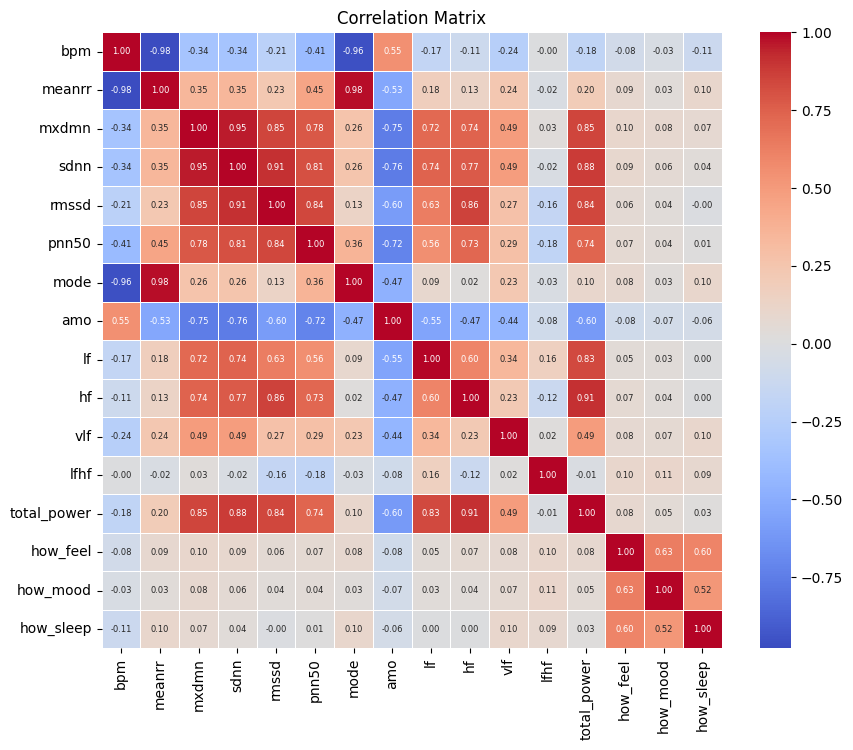

In [36]:
# Calculate the correlation matrix for the numeric columns in the hrv_measurements DataFrame
print("Correlation Matrix")
correlation_matrix = hrv_measurements[numeric_columns].corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, annot_kws={"size": 6}, fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()


### Interpretations

1. **Diagonal Values**: All diagonal values are 1 (in red) since each feature is perfectly correlated with itself.

2. **Strong Negative Correlations**:

   - `bpm` and `meanrr`: A strong negative correlation (-0.98), which makes sense since heart rate (bpm) and RR intervals (meanrr) are inversely related.

   - `bpm` and `mode`: Another strong negative correlation (-0.96), which could indicate that the mode (most frequent RR interval) is highly influenced by the heart rate.

   - `amo` and `sdnn` (-0.75), `amo` and `mxdmn` (-0.75): These features are negatively correlated, possibly indicating opposing behavior in variability and amplitude-related measurements.

3. **Strong Positive Correlations**:

   - `meanrr` and `mode`: A very high positive correlation (0.98), meaning that the most frequent RR interval (mode) tends to increase as the mean RR interval increases.

   - `sdnn` and `mxdmn`: A strong positive correlation (0.95), which shows that as variability in heart rate (sdnn) increases, the max-min RR difference (mxdmn) also tends to increase.

   - `total_power` and `mxdmn` (0.85): Strong positive correlation, indicating that higher power in the frequency domain corresponds to greater RR interval range (mxdmn).

   - `total_power` and `lf` (0.83), `total_power` and `hf` (0.91): Indicates that total spectral power is positively associated with both low-frequency and high-frequency components.

4. **Low/Weak Correlations**:

   - `how_feel` and `most features`: The feature `how_feel` (possibly representing subjective wellness) shows weak correlations with most features, except for `how_mood`, which has a moderately positive correlation (0.63). This suggests that feelings and mood might be related but are not strongly tied to physiological metrics like heart rate variability.

   - `bpm` and other frequency-domain features (lf, hf, vlf): Weak correlations between heart rate and frequency components suggest bpm has little to no direct influence on these spectral measures.

# Visualizatons


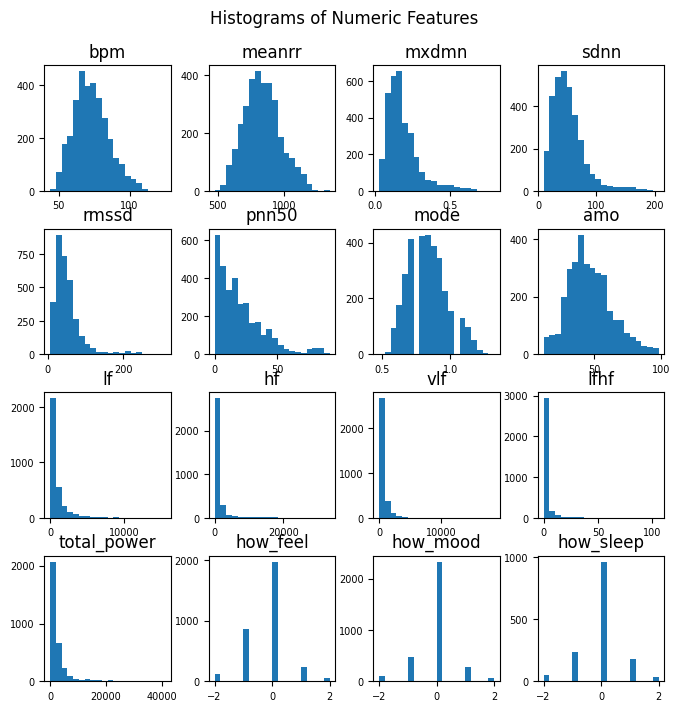

In [37]:
# Visualization of the distribution of numeric features
hrv_measurements[numeric_columns].hist(bins=20, figsize=(8,8), grid=False, xlabelsize=7 , ylabelsize=7)
plt.suptitle("Histograms of Numeric Features", y=0.95)
plt.show()

### Interpretations

- Skewness: Several features exhibit right skewness, particularly mxdmn, sdnn, total_power, and the frequency domain features (lf, hf, vlf). This suggests that most observations cluster at lower values, with a few outliers in the higher ranges.

- Outliers: There are noticeable outliers in the total_power, lf, hf, and vlf features, which we previously noted.

- Categorical-like Features: Features such as how_feel, how_mood, and how_sleep appear to be categorical or ordinal in nature, with most observations centered around neutral responses.

<function matplotlib.pyplot.show(close=None, block=None)>

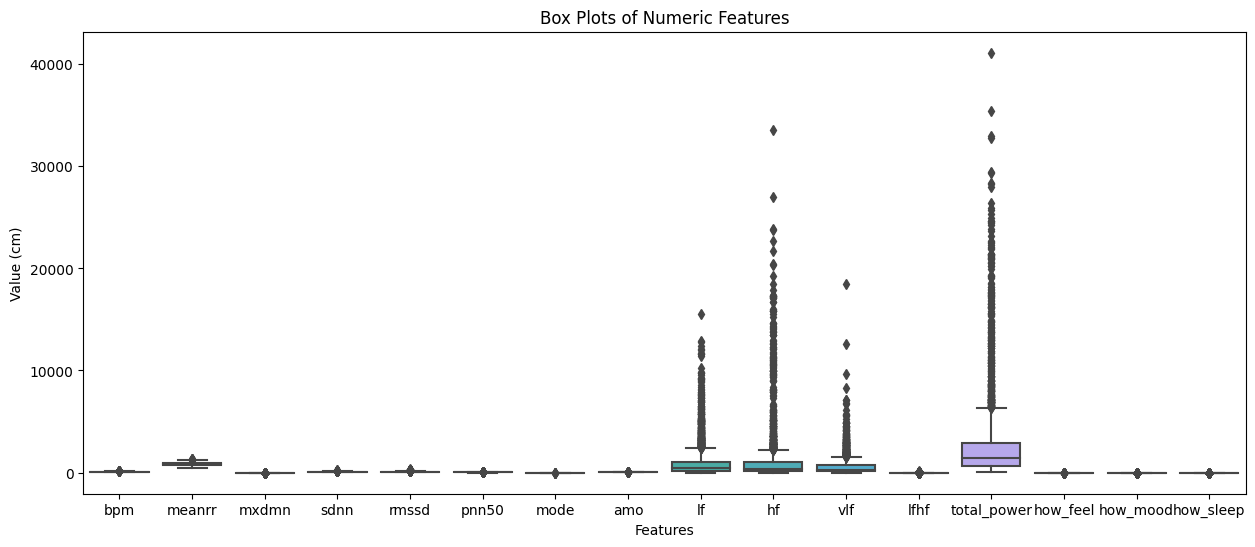

In [38]:
# Box plots visualization for numeric features
plt.figure(figsize=(15,6))
sns.boxplot(data=hrv_measurements[numeric_columns])
plt.title("Box Plots of Numeric Features")
plt.xlabel("Features")
plt.ylabel("Value (cm)")
plt.show

# Handling Missing Values, Outliers, Duplicates

In [39]:
# Drop specified columns from the hrv_measurements DataFrame
hrv_measurements = hrv_measurements.drop(columns=['mode','how_mood','how_sleep','tags'])

# Update the numeric_columns variable to include only the numeric columns from the modified DataFrame
numeric_columns = hrv_measurements.select_dtypes(include=[np.number]).columns

### Outliers

Since we lack domain-specific knowledge about heart rate variability (HRV) metrics, such as `total_power`, `lf`, `hf`, and `vlf`, we are unable to confidently remove outliers from these features. The presence of what appear to be significant outliers might actually reflect true physiological variations, rather than data errors or anomalies. For example, higher or lower values in HRV-related features could be indicative of varying health conditions, levels of stress, or fitness that differ naturally between individuals.

Without a deep understanding of what constitutes an "acceptable" range for these features, removing outliers could result in a loss of critical information or potentially bias the analysis. Therefore, we have opted to retain these outliers in our dataset for now, as they may offer valuable insights later in the modeling or domain-specific analysis stages.

### Duplicates

Upon checking the dataset, we found **no duplicate records** that require further attention. Thus, we do not need to apply any procedures for removing duplicates.

### Missing Values

We observed a large number of missing values in the **"how_sleep"** and **"tags"** columns. Specifically:

- The `how_sleep` feature has missing data in approximately **55%** of the rows (1779 missing values).

- The `tags` feature has missing data in about **32%** of the rows (1044 missing values).

Given the high proportion of missing values in both of these features, we have decided to **remove these columns** from further analysis. Imputation would not be appropriate here, as the amount of missing data is too substantial, and filling in such gaps could introduce significant bias or noise. Additionally, the "tags" feature may not provide direct insights relevant to our main objective of analyzing heart rate variability.


### For feature selection, these columnns have been removed:

1. **Mode**: 

   - The `mode` feature represents a right-skewed distribution with limited variability in the dataset. Since it highly correlates with other heart rate variability (HRV) features, like `meanrr` and `pnn50` (as seen in the correlation matrix), it does not add much new information and may cause redundancy. Its high correlation with other variables suggests it can be removed to avoid multicollinearity in the model.

2. **How_Mood**:

   - `how_mood` is a **categorical/ordinal variable** representing subjective mood states. Since it has only a few distinct values (as shown in the histogram), it may not provide enough variability or predictive power for the target variable. Additionally, it shows very low correlation with other HRV measurements, suggesting it is not highly impactful for physiological analysis. 

3. **How_Sleep**:

   - While not visible in the visualizations provided, **subjective sleep quality** (`how_sleep`) may not have a direct correlation with physiological HRV measurements. Similar to mood, sleep quality is self-reported and may not add significant value to the objective measurements like heart rate or other HRV metrics. Since subjective variables like these can introduce noise, they are removed for a cleaner analysis of objective HRV features. Moreover, this feature has a significant amount of null values.

4. **Tags**:

   - `tags` is likely a **categorical or textual variable** representing event labels or annotations. These types of columns are often unstructured and may not contribute directly to numerical HRV analysis. Including them could require additional preprocessing (like encoding or NLP techniques) and may not offer meaningful insights for feature engineering focused on physiological measurements. Additionally, this feature has a significant amount of null values.

# Data Transformation

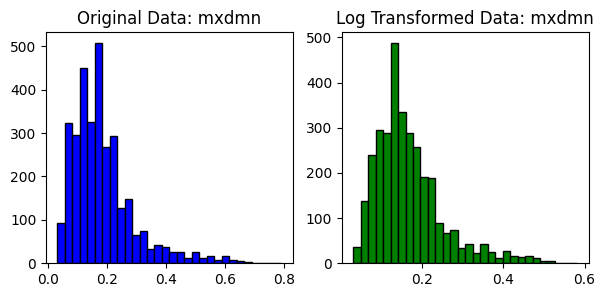

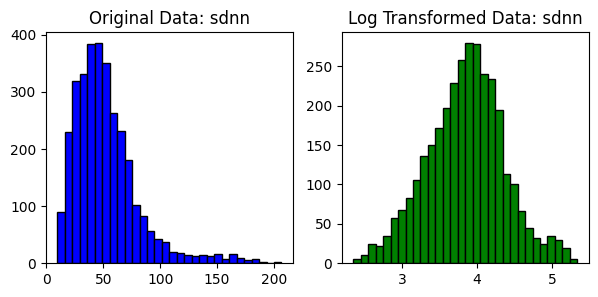

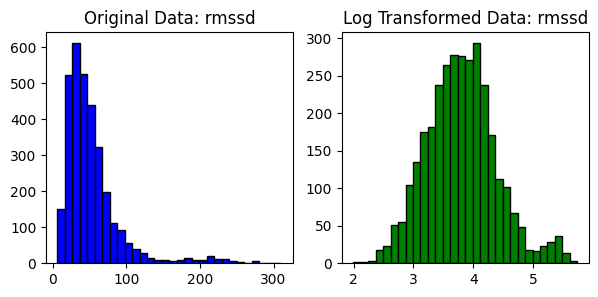

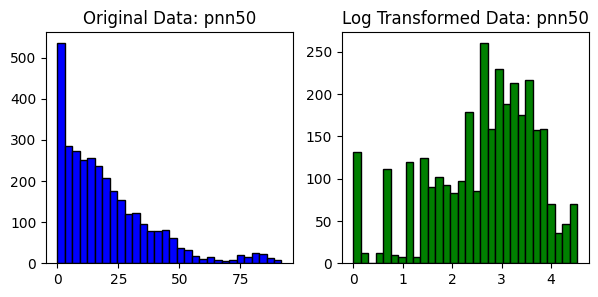

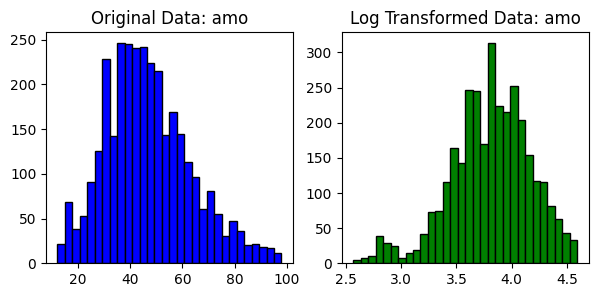

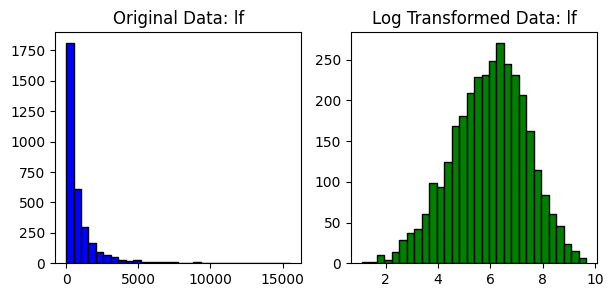

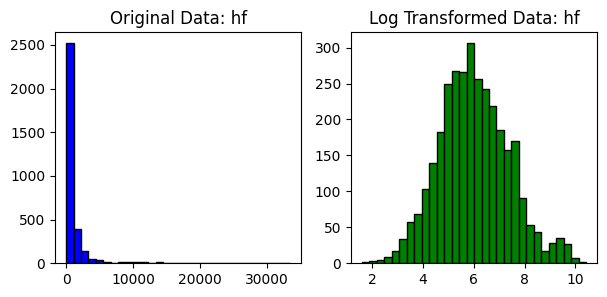

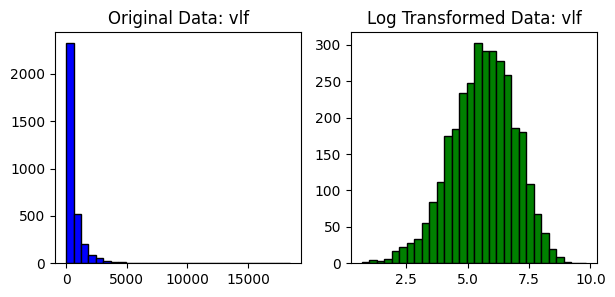

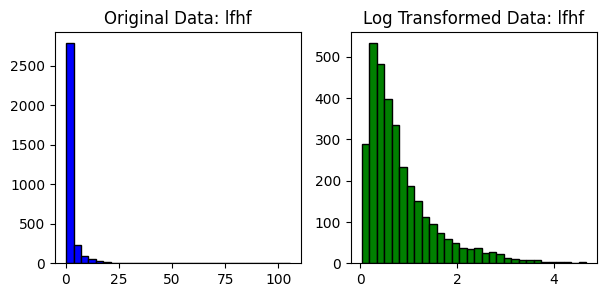

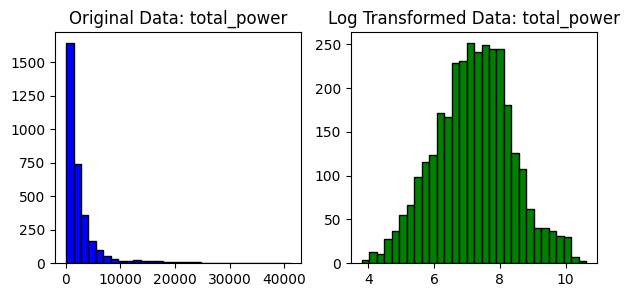

In [40]:
# Checking skewness of numeric columns
skewness = hrv_measurements[numeric_columns].apply(lambda x: skew(x.dropna()))

# Applying log transformation to skewed columns
skewed_columns = skewness[skewness > 0.5].index  # Select highly skewed columns
hrv_measurements[skewed_columns] = hrv_measurements[skewed_columns].apply(lambda x: np.log1p(x))  # log1p(x) = log(1 + x)

# Plot histograms before and after log transformation
for col in skewed_columns:
    plt.figure(figsize=(7, 3))

    # Original data
    plt.subplot(1, 2, 1)
    plt.hist(hrv_measurements[col].apply(np.expm1), bins=30, color='blue', edgecolor='black')
    plt.title(f'Original Data: {col}')

    # Log-transformed data
    plt.subplot(1, 2, 2)
    plt.hist(hrv_measurements[col], bins=30, color='green', edgecolor='black')
    plt.title(f'Log Transformed Data: {col}')

    plt.show()

### Interpretation

- This code performs an analysis of skewness on the numeric columns and applies a log transformation to those columns that exhibit high skewness. The purpose of this procedure is to normalize the data distribution, making it more suitable for statistical analysis.

- For the columns identified as skewed, a log transformation is applied using the `np.log1p()` function. This function computes the natural logarithm of `1 + x`, which is particularly useful for transforming data that includes zero or positive values, avoiding undefined logarithmic results.

- The left subplot shows the **Original Data**, where the `np.expm1` function is used to reverse the log transformation for visualization purposes, allowing a comparison in the original scale.

- The right subplot presents the **Log Transformed Data**, illustrating the effect of the transformation on the data distribution.


In [41]:
# Initialize the MinMaxScaler from sklearn to scale numeric features
scaler = MinMaxScaler()

# Apply Min-Max scaling to the numeric columns of the hrv_measurements DataFrame
hrv_measurements[numeric_columns] = scaler.fit_transform(hrv_measurements[numeric_columns])

### Interpretation

- The `MinMaxScaler` scaler transforms features by scaling each feature to a given range, typically between 0 and 1.

- The `fit_transform` method is applied to the specified numerical columns (`numeric_columns`).

- This method first calculates the minimum and maximum values of each numeric feature and then scales the data according to the formula:

     $
     X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
     $

- As a result, each feature will be rescaled to fall within the range of 0 to 1, maintaining the relative relationships between the values while normalizing the scale.

### One new feature is engineered and documented


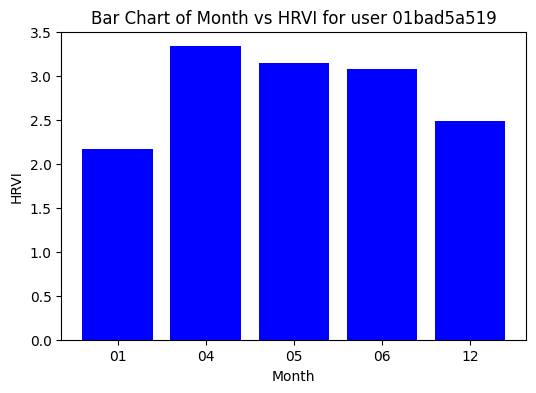

In [42]:
# Creating new feature - HRVI
hrv_measurements['hrvi'] = (hrv_measurements['sdnn'] + hrv_measurements['rmssd'] + hrv_measurements['pnn50']) / hrv_measurements['total_power']

# Selecting only 1 user to visualize as a bar chart
hrv_fea_engg = hrv_measurements[hrv_measurements['user_code']=='01bad5a519'][['user_code','measurement_datetime','hrvi']]

# change datatype and extract month from measurement_datetime
import datetime as dt
hrv_fea_engg['measurement_datetime'] = pd.to_datetime(hrv_fea_engg['measurement_datetime'])
hrv_fea_engg['month'] = hrv_fea_engg['measurement_datetime'].dt.strftime('%m')
hrv_fea_engg = hrv_fea_engg.drop(["measurement_datetime"], axis=1)
hrv_fea_engg = hrv_fea_engg.drop(["user_code"], axis=1)

# Visualize as bar chart
plt.figure(figsize=(6,4))
plt.bar(hrv_fea_engg.groupby('month').mean().reset_index()['month'], hrv_fea_engg.groupby('month').mean().reset_index()['hrvi'], color='blue')
plt.title('Bar Chart of Month vs HRVI for user 01bad5a519')
plt.xlabel('Month')
plt.ylabel('HRVI')
plt.show()

### Interpretation

The **Heart Rate Variability Index (HRVI)** is a newly created feature that represents a combined measure of heart rate variability. Here's how we likely created the HRVI feature:

- **HRV Metrics**: The dataset contains several heart rate variability-related features, such as `sdnn`, `rmssd`, `pnn50`, `lf`, `hf`, and `total_power`. These are standard metrics used to analyze variations in heart rate intervals, reflecting the autonomic nervous system's regulation.
- **HRVI Calculation**: HRVI is typically derived by combining some of these features to create a composite index that reflects the overall variability in heart rate. For example, HRVI could be calculated as:
  
  $
  HRVI = \frac{sdnn + rmssd + pnn50}{total\_power}
  $

  This formula includes time-domain features (`sdnn`, `rmssd`, `pnn50`) and normalizes them by the total spectral power (`total_power`) in the frequency domain, giving a holistic view of heart rate variability.

- **Purpose of HRVI**: By creating the HRVI, we can more easily track changes in heart rate variability over time, as a single metric can often be more intuitive to interpret than multiple separate features. This can be useful for understanding patterns related to stress, relaxation, or overall heart health.

In this case, the bar chart highlights how the user's HRVI fluctuates over different months, potentially revealing seasonal or lifestyle-related trends in heart rate variability.
The bar chart shows the relationship between **months** and **Heart Rate Variability Index (HRVI)** for a specific user (user ID: `01bad5a519`). Each bar represents the HRVI value for different months, which are labeled as `01`, `04`, `05`, `06`, and `12`.

### A dimensionality reduction method is performed and interpreted

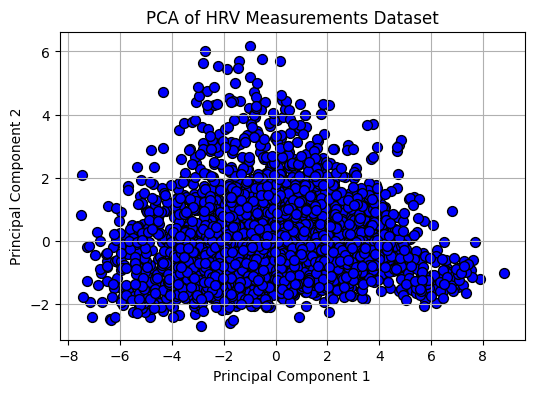

In [43]:
# Standard Scaling
scaler = StandardScaler()
hrv_scaled = scaler.fit_transform(hrv_measurements[numeric_columns])

# Creating PCA model
pca = PCA(n_components=2)
principal_components = pca.fit_transform(hrv_scaled)

# Creating a new DataFrame to hold the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Visualize final dataframe with 2 dimensions
plt.figure(figsize=(6,4))
plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c='blue', edgecolor='k', s=50)
plt.title('PCA of HRV Measurements Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

### Interpretation

- PCA was used to reduce the number of features in the HRV dataset to two principal components. This allows for easier visualization and analysis, while retaining as much of the variance in the data as possible.

- PCA helps in identifying patterns or clusters by transforming correlated features into uncorrelated principal components.

- The plot is well spread, indicating that the first two components capture a decent amount of variance in the dataset.

- The points do not form distinct clusters, which suggests that there is not a clear, inherent grouping in the data, though there is a general spread across both components.

- The absence of clustering or separation could indicate that the features used in the HRV dataset do not show any obvious groupings, or that more components would need to be considered for better insights.

# Data Quality Assessment

In this section, we discuss the various components of our data quality assessment process for the Heart Rate Variability (HRV) dataset. This comprehensive evaluation ensures the reliability and integrity of our data, which is crucial for accurate analysis and meaningful insights.

### 1. Data Profiling

Our data profiling process involved a thorough examination of the HRV dataset's structure, content, and relationships. We analyzed:

- Data types of each column (e.g., numeric for HRV metrics, datetime for measurement timestamps)
- Distributions of numeric features (as seen in our histograms and box plots)
- Basic statistics (mean, median, standard deviation) for numeric columns
- Unique values and frequencies for categorical columns (e.g., 'time_of_day', 'user_code')

This profiling provided valuable insights into the overall characteristics of our data, helping us understand the nature of our HRV measurements and guiding our subsequent analysis steps.

### 2. Data Completeness

We assessed the completeness of our dataset by:

- Identifying missing values in each column
- Calculating the percentage of missing data

Our analysis revealed significant missing data in the 'how_sleep' (55%) and 'tags' (32%) columns. Due to the high proportion of missing values, we decided to remove these columns to maintain the integrity of our analysis. For the remaining columns, we found no missing values, ensuring a complete dataset for our core HRV metrics.

### 3. Data Accuracy

To ensure the accuracy of our HRV data, we:

- Checked for outliers using box plots and histograms
- Compared the range of values for each HRV metric against known physiological limits
- Examined the correlation matrix to verify expected relationships between HRV metrics

While we observed some extreme values, particularly in frequency-domain metrics (lf, hf, vlf), we retained these as they may represent genuine physiological variations. Further domain expertise would be beneficial to definitively identify any inaccurate measurements.

### 4. Data Consistency

We evaluated data consistency by:

- Comparing related metrics (e.g., 'bpm' and 'meanrr') to ensure logical relationships
- Checking for consistent units of measurement across all HRV metrics
- Verifying that categorical data (e.g., 'time_of_day') used consistent naming conventions

Our analysis showed high consistency in the core HRV metrics. The strong negative correlation between 'bpm' and 'meanrr' (-0.98) aligns with the expected inverse relationship between heart rate and RR intervals.

### 5. Data Integrity

To maintain data integrity, we:

- Checked for duplicate records (none found)
- Ensured that all numeric columns contained only numeric data
- Verified that datetime columns were in a consistent format

Our dataset demonstrated high integrity, with no duplicates and consistent data types across columns. This suggests that the data collection and initial processing steps were robust.

### 6. Data Lineage and Provenance

Understanding the origin and transformations of our data is crucial. For this HRV dataset:

- Source: We noted that the data came from the "Welltory COVID-19 and Wearables Open Data Research" project on Github.
- Collection Method: Data was collected using Bluetooth-enabled heart rate monitors or smartphone cameras (Photoplethysmography).
- Preprocessing: While specific details weren't provided, we know that Welltory applies signal processing techniques to the raw data to derive HRV metrics.
- Transformations: In our analysis, we applied log transformations to skewed features and used Min-Max scaling on numeric columns.

This lineage information helps us understand the context of our data and any potential limitations or biases introduced during collection and processing.

In conclusion, our data quality assessment reveals a dataset of generally high quality, particularly in terms of completeness and consistency of the core HRV metrics. The main quality concerns relate to the removed columns with high proportions of missing data and potential outliers in some frequency-domain metrics. These findings inform our analysis approach and highlight areas where caution or further investigation may be necessary.